In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import random
import graphviz
import seaborn as sns
import time
import math
from torch.nn.utils import clip_grad_norm_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
path_1 = "/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Deep Q Learning/nn_training_data_first_half.csv"
path_2 = "/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Deep Q Learning/nn_training_data_second_half.csv"

offline_TTT_trajectories_first_half = pd.read_csv(path_1).to_numpy()
offline_TTT_trajectories_second_half = pd.read_csv(path_2).to_numpy()

offline_TTT_trajectories = np.concatenate((offline_TTT_trajectories_first_half, offline_TTT_trajectories_second_half), axis=0)
print(offline_TTT_trajectories.shape)

In [7]:
# 1. Define your environment
class TicTacToe:
  def __init__(self):
    self.board = np.zeros((3, 3))

  def reset(self):
    self.board = np.zeros((3, 3))
    return self.board

  def check_win(self, player):
    # Check rows
    for i in range(3):
      if np.all(self.board[i, :] == player):
        return player

    # Check columns
    for j in range(3):
      if np.all(self.board[:, j] == player):
        return player

    #Check diagonal
    if np.all(np.diag(self.board) == player):
      return player
    if np.all(np.diag(np.fliplr(self.board)) == player):
      return player

    #Check tie
    if np.all(self.board != 0):
      return -1

    return 0

  # Check for empty places on board
  def possibilities(self):
    l = []
    print(self.board)
    for i in range(len(self.board)):
        for j in range(len(self.board)):

            if self.board[i][j] == 0:
                l.append((i, j))
    return(l)

  def random_step(self, player):
    selection = self.possibilities()
    current_loc = random.choice(selection)
    self.board[current_loc] = player
    done = self.check_win(player)
    reward = 0
    if done == 2:
      reward = -1
    return self.board, reward, done

  def network_step(self, action, player):
    #print(action)
    row, col = action
    self.board[row, col] = player
    done = self.check_win(player)
    reward = 0
    if done == 1:
      reward = 1
    return self.board, reward, done



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class TransformerAgent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, nhead, num_layers, dropout=0.1):
        super(TransformerAgent, self).__init__()
        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=nhead,
                                          num_decoder_layers=num_layers,
                                          num_encoder_layers=num_layers,
                                          dropout=dropout)
        # Instead of an Embedding layer, use a Linear layer to handle continuous state values
        self.state_embedding = nn.Linear(state_dim, hidden_dim)
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.state_dim = state_dim

    def forward(self, x):
        # Embed the input using the Linear layer
        x = self.state_embedding(x.float())
        # Reshape to (sequence_length, batch_size, embedding_dim)
        x = x.view(1, 1, -1) # Reshape for Transformer

        # Pass through the Transformer
        output = self.transformer(x, x)[0, -1, :]
        # Actor output (logits)
        logits = self.actor(output)
        return logits

In [4]:
tensor_to_tuple = {}
for i in range(9):
  tensor_to_tuple[i] = (i//3, i%3)
print(tensor_to_tuple)

{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}


In [23]:
from logging import log
#Tic Tac Toe version
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    discounted_reward = 0
    i = 0
    for reward in reversed(rewards):
        discounted_reward = reward + gamma * discounted_reward
        discounted_rewards.insert(0, discounted_reward)
        #print(i," discounted_rewards: ", discounted_rewards)
        i += 1
    discounted_rewards = torch.tensor(discounted_rewards)

    discounted_rewards = discounted_rewards / (discounted_rewards.std() + 1e-5)
    #discounted_rewards = discounted_reward - discounted_rewards.mean() / (discounted_rewards.std() + 1e^-5)
    # print("discounted rewards: ", discounted_rewards)
    # print("discounted rewards mean: ", discounted_rewards.mean())
    # print("discounted rewards std: ", discounted_rewards.std())

    return discounted_rewards

#%%debug
debug = False

def train(env, policy, optimizer, episodes=10000):

  games_won = 0
  games_lost = 0
  games_skipped = 0
  for episode in range(episodes):
    print("trajectory: ", episode)
    state = env.reset()
    log_probs = []
    rewards = []


    done = 0
    not_done_counter = 0
    while done == 0:
        print(state)
        action_mask = np.zeros((3, 3))

        for i in range(len(action_mask)):
          for j in range(len(action_mask)):
            if state[(i,j)] == 0:
              action_mask[i][j] = 1
        action_mask = torch.FloatTensor(action_mask.flatten())

        if debug:
          print("inner episode loop ", not_done_counter)

        state = torch.FloatTensor(state.flatten()).unsqueeze(0)
        if debug:
          print("inner episode loop ", not_done_counter, " state: ", state)

        probs = policy(state)
        if debug:
          print("inner episode loop ", not_done_counter, " probs: ", probs)

        # Apply softmax to the logits to get probabilities
        probs = torch.softmax(probs, dim=-1)
        # Then apply the action mask
        masked_probs = probs * action_mask
        # Renormalize to ensure they sum to 1
        masked_probs = masked_probs / masked_probs.sum()

        action_probabilities = Categorical(masked_probs)
        if debug:
          print("inner episode loop ", not_done_counter, " action_probabilities: ", action_probabilities)

        action = action_probabilities.sample()
        if debug:
          print("inner episode loop ", not_done_counter, " action: ", action)
          print("")
          print("")
          print("")

        if debug:
          print("inner episode loop ", not_done_counter, "step input action.item(): ", action.item())



        state, reward, done = env.network_step(tensor_to_tuple[action.item()], player = 1)

        #Only generate random move is state is not terminal
        if done == 0:
          state, reward, done = env.random_step(player = 2)
        if debug:
          print("inner episode loop after step ", not_done_counter)
          print("step output state: \n", state)
          print("step output reward: ", reward)
          print("step output done: ", done)
          print("")
          print("")
          print("")



        log_probs.append(action_probabilities.log_prob(action))
        rewards.append(reward)

        # Inside the train function, after an episode ends:
        if done != 0:
            print(state)
            print("DONE!!! ", done)
            if sum(rewards) == 1:
              games_won += 1
            elif sum(rewards) == -1:
              games_lost += 1
            episode_rewards.append(sum(rewards))
            discounted_rewards = compute_discounted_rewards(rewards)

            policy_loss = []
            for log_prob, Gt in zip(log_probs, discounted_rewards):
                # Convert log_prob to a 1-dimensional tensor before appending
                policy_loss.append((-log_prob * Gt).unsqueeze(0))
            optimizer.zero_grad()
            # Now you can safely concatenate and sum
            policy_loss = torch.cat(policy_loss).sum()
            policy_loss.backward()
            optimizer.step()
            episode_losses.append(policy_loss.item())


            if episode % 50 == 0:
                print(f"Episode {episode}, Total Reward: {sum(rewards)}")
                print("games_won: ", games_won)
                print("games lost: ", games_lost)
                print("games_skipped: ", games_skipped)
                print("")
                print("")
                print("")

            break



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Globals
episode_rewards = []
episode_losses = []

#Driver code for training the model
my_env = TicTacToe()
print("")
policy = TransformerAgent(state_dim=9, action_dim=9, hidden_dim=128, nhead=8, num_layers=6)
print("Policy: ", policy)
total_params = sum(p.numel() for p in policy.parameters())
print(f"Number of parameters: {total_params}")
optimizer = optim.Adam(policy.parameters(), lr=1e-6)

#train(env, policy, optimizer)
train(my_env, policy, optimizer)


Policy:  TransformerAgent(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): Multi

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Streaming output truncated to the last 5000 lines.
 [2. 1. 1.]
 [1. 2. 0.]]
[[1. 2. 2.]
 [2. 1. 1.]
 [1. 2. 1.]]
DONE!!!  1
trajectory:  2917
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
[[0. 2. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
[[0. 2. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
[[2. 2. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
[[2. 2. 1.]
 [1. 1. 0.]
 [0. 0. 0.]]
[[2. 2. 1.]
 [1. 1. 2.]
 [0. 0. 0.]]
[[2. 2. 1.]
 [1. 1. 2.]
 [0. 1. 0.]]
[[2. 2. 1.]
 [1. 1. 2.]
 [0. 1. 2.]]
[[2. 2. 1.]
 [1. 1. 2.]
 [1. 1. 2.]]
DONE!!!  1
trajectory:  2918
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [2. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [2. 1. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [2. 1. 0.]
 [0. 2. 0.]]
[[1. 1. 0.]
 [2. 1. 0.]
 [0. 2. 0.]]
[[1. 1. 2.]
 [2. 1. 0.]
 [0. 2. 0.]]
[[1. 1. 2.]
 [2. 1. 0.]
 [1. 2. 0.]]
[[1. 1. 2.]
 [2. 1. 2.]
 [1. 2. 0.]]
[[1. 1. 2.]
 [2. 1. 2.]
 [1. 2. 1.]]
DONE!!!  1
trajectory:  2919
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 0. 0.]
 [0. 0. 0.]

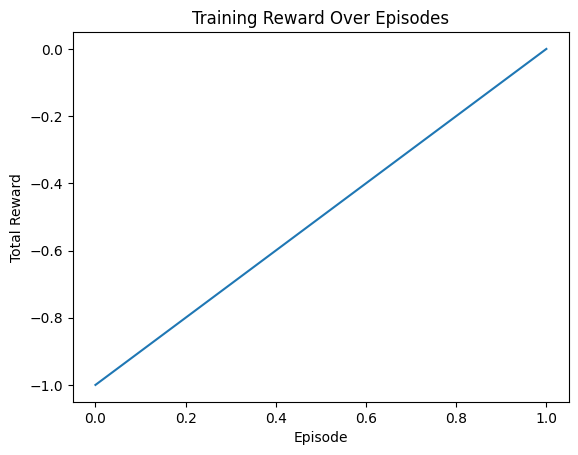

In [17]:
cumulative_episode_rewards = []
for i in range(len(episode_rewards)):
  if i == 0:
    cumulative_episode_rewards.append(episode_rewards[i])
  else:
    cumulative_episode_rewards.append(cumulative_episode_rewards[i-1] + episode_rewards[i])


plt.plot(cumulative_episode_rewards)
plt.title('Training Reward Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()